# Flip-contrained SCA

For SCA dynamics, we plot a sample of the modified Hamiltonian in "Step-Energy graph".  For flip-constrained SCA dynamics, we plot a sample of the (original) Hamiltonian in "Step-Energy graph".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import simulatorWithCpp as simulator
import math

%matplotlib inline
np.set_printoptions(threshold=16, edgeitems=8)

## Annealing

In [2]:
maxSteps = int(3.e3)
MaxTrials = int(1.e2)
NumNodes = 256
SeedForConfiguration = 1024

def MakeUniformConfiguration(numNodes, seed=None):
    rng = np.random.default_rng(seed)
    return {i: rng.choice([-1, +1]) for i in range(numNodes)}

InitialConfiguration = MakeUniformConfiguration(NumNodes, SeedForConfiguration)

def TryExperimentFor(isingModel, initialTemperature):
    minimumEnergiesData = np.empty(0, dtype=float)
    samples = np.empty((maxSteps + 1, 4), dtype=float)
    #isingModel.Write()
    for i in range(MaxTrials):
        isingModel.Spins = InitialConfiguration
        isingModel.SetSeed()
        for n in range(maxSteps + 1):
            isingModel.Temperature = initialTemperature * 0.99 ** n
            #isingModel.Temperature = 100 * np.exp(-0.005 * n)
            isingModel.Update()
            samples[n, 0] = n
            samples[n, 1] = isingModel.Temperature
            samples[n, 2] = isingModel.Energy
            samples[n, 3] = isingModel.EnergyOnBipartiteGraph
        minimumEnergiesData = np.append(minimumEnergiesData, samples[:, 2].min())

    print('Mean: {}'.format(np.mean(minimumEnergiesData)))
    print('Standard deviation: {}'.format(np.std(minimumEnergiesData)))
    print('Mode: {}'.format(stats.mode(minimumEnergiesData)))
    print('Minimum: {}'.format(np.min(minimumEnergiesData)))

    fig = plt.figure(figsize=(7, 3), dpi=100)
    ax = fig.add_subplot(121, xlabel='MC steps', ylabel='Energy')
    ax.grid()
    ax.plot(samples[:, 0], samples[:, 2], label='Original Hamiltonian')
    ax.plot(samples[:, 0], samples[:, 3], label='Double Hamiltonian')
    ax.legend()
    ax = fig.add_subplot(122, xlabel='Energy', ylabel='Frequency')
    ax.grid(which='both')
    ax.hist(minimumEnergiesData, bins=30)
    fig.suptitle(isingModel.Algorithm.name)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

### Square lattice

In [3]:
def GenerateSquareLatticeEdges(numNodes):
    columns = math.ceil(math.sqrt(numNodes))
    result = {}
    for i in range(numNodes - 1):
        if (i + 1) % columns > 0:
            result[(i, i + 1)] = -1
        if (i + columns) < numNodes:
            result[(i, i + columns)] = -1
    return result

quadratic = GenerateSquareLatticeEdges(NumNodes)
isingModel = simulator.IsingModel({}, quadratic)
T0 = 2.e0 * np.sum([np.abs(J) for J in quadratic.values()])

In [ ]:
isingModel.Algorithm = simulator.Algorithms.SCA
isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

In [ ]:
isingModel.Algorithm = simulator.Algorithms.fcSCA
isingModel.PinningParameter = 0.125e0 * isingModel.CalcLargestEigenvalue()
isingModel.FlipTrialRate = 0.8e0
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

### Complete graph

In [ ]:
def GenerateCompleteGraphEdges(numNodes):
    return {(i, j): -1 for i in range(numNodes) for j in range(i + 1, numNodes)}

quadratic = GenerateCompleteGraphEdges(NumNodes)
isingModel = simulator.IsingModel({}, quadratic)
T0 = 2.e0 * np.sum([np.abs(J) for J in quadratic.values()])

In [ ]:
isingModel.Algorithm = simulator.Algorithms.SCA
isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

In [ ]:
isingModel.Algorithm = simulator.Algorithms.fcSCA
isingModel.PinningParameter = 0.e0
isingModel.FlipTrialRate = 0.3e0
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

### Erdős-Rényi random graph

In [4]:
OccupationProbability = 0.5e0
SeedForRandomGraph = 2048

def GenerateErdosRenyiEdges(numNodes, probability):
    rng = np.random.Generator(np.random.MT19937(SeedForRandomGraph))
    return {(i, j): -1 if rng.random() <= probability else 0 for i in range(numNodes) for j in range(i + 1, numNodes)}

quadratic = GenerateErdosRenyiEdges(NumNodes, OccupationProbability)
isingModel = simulator.IsingModel({}, quadratic)
T0 = 2.e0 * np.sum([np.abs(J) for J in quadratic.values()])

Mean: -670.54
Standard deviation: 86.95141401955462
Mode: ModeResult(mode=array([-661.]), count=array([5]))
Minimum: -963.0


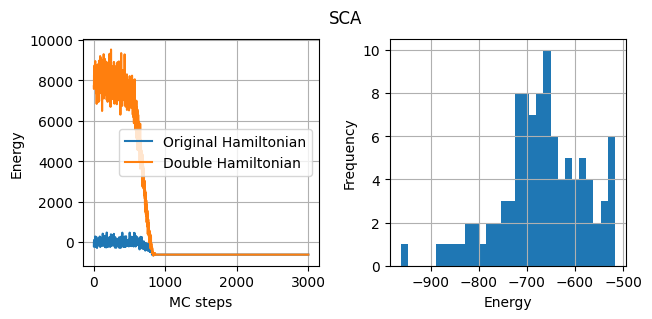

In [5]:
isingModel.Algorithm = simulator.Algorithms.SCA
isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

Mean: -1502.64
Standard deviation: 23.18685834691712
Mode: ModeResult(mode=array([-1517.]), count=array([7]))
Minimum: -1545.0


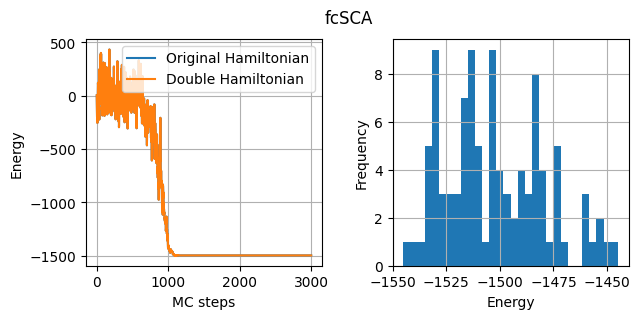

In [10]:
isingModel.Algorithm = simulator.Algorithms.fcSCA
isingModel.PinningParameter = 0.e0
isingModel.FlipTrialRate = 0.2e0
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

### Bruno's method

In [6]:
maxSteps = int(6.e3)
MaxTrials = int(1.e2)
NumNodes = 256
SeedForConfiguration = 1024

def MakeUniformConfiguration(numNodes, seed=None):
    rng = np.random.default_rng(seed)
    return {i: rng.choice([-1, +1]) for i in range(numNodes)}

InitialConfiguration = MakeUniformConfiguration(NumNodes, SeedForConfiguration)

def TryExperimentFor(isingModel, initialTemperature):
    minimumConfiguration = MakeUniformConfiguration(NumNodes, SeedForConfiguration)
    fig = plt.figure(figsize=(3, 21), dpi=100)
    for i in range(7):
        isingModel.Spins = minimumConfiguration
        isingModel.SetSeed()
        minimumEnergy = isingModel.Energy
        samples = np.empty((maxSteps + 1, 4), dtype=float)
        for n in range(maxSteps + 1):
            #isingModel.Temperature = initialTemperature * 0.99 ** n
            #isingModel.Temperature = 100 * np.exp(-0.005 * n)
            if i == 0:
                isingModel.Temperature = 1.e0 / 0.0001 * np.exp(-0.003 * n)
            else:
                isingModel.Temperature = 1.e0 / 0.5 * np.exp(-0.00005 * n)
            isingModel.Update()
            samples[n, 0] = n
            samples[n, 1] = isingModel.Temperature
            samples[n, 2] = isingModel.Energy
            samples[n, 3] = isingModel.EnergyOnBipartiteGraph
            if samples[n, 2] < minimumEnergy:
                minimumEnergy = samples[n, 2]
                minimumConfiguration = isingModel.Spins
        print(minimumEnergy)

        ax = fig.add_subplot(7, 1, i + 1, xlabel='MC steps', ylabel='Energy')
        ax.grid()
        ax.plot(samples[:, 0], samples[:, 2], label='Original Hamiltonian')
        ax.plot(samples[:, 0], samples[:, 3], label='Double Hamiltonian')
        ax.legend()
    #plt.subplots_adjust(wspace=0.3)
    plt.show()

-1511.0
-1527.0
-1551.0
-1551.0
-1551.0
-1551.0
-1551.0


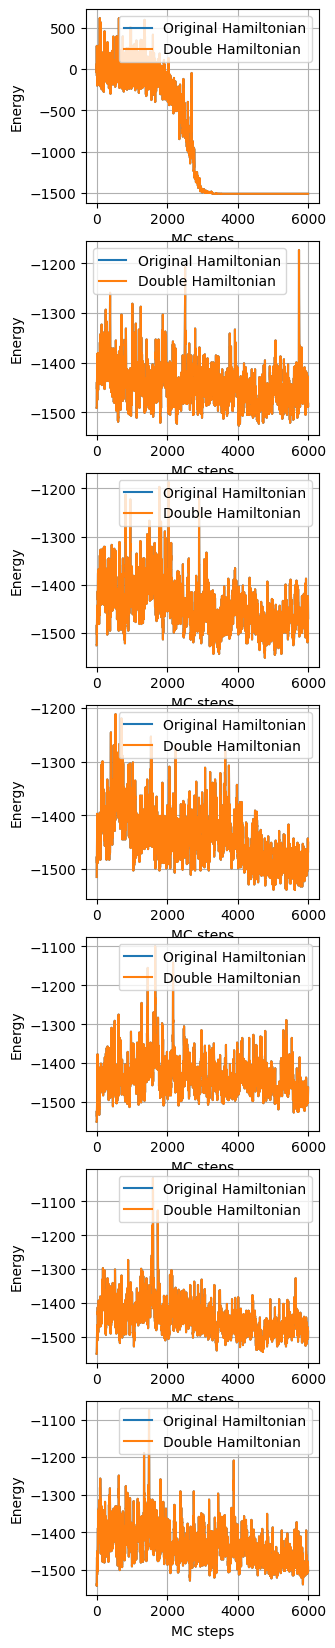

In [7]:
isingModel.Algorithm = simulator.Algorithms.fcSCA
isingModel.PinningParameter = 0.e0
isingModel.FlipTrialRate = 0.2e0
TryExperimentFor(isingModel, T0 + NumNodes * isingModel.PinningParameter)

## Antiferromagnet on a complete graph for the low temperature limit

Consider the antiferromagnet $J_{x, y} = -1$ with $h_x = 0$ and $q_x = 0$ on a complete graph.
Taking the low temerature limit,
$$
    \lim_{\beta\uparrow\infty} P_\epsilon(\sigma, \tau)
    = \prod_{x\in D_{\sigma, \tau}} \left(\epsilon \left(\frac{1}{2} \mathbf{1}_{\{\sum_{y\sim x} \sigma_x \sigma_y = 0\}} + \mathbf{1}_{\{\sum_{y\sim x} \sigma_x \sigma_y > 0\}}\right)\right)
        \prod_{x\in D_{\sigma, \tau}^\complement} \left(1 - \epsilon \left(\frac{1}{2} \mathbf{1}_{\{\sum_{y\sim x} \sigma_x \sigma_y = 0\}} + \mathbf{1}_{\{\sum_{y\sim x} \sigma_x \sigma_y > 0\}}\right)\right).
$$

The following graphs are the system energies per monte carlo step for $\lvert V\rvert = 100$ and each $\epsilon\in [0, 1]$.

In [ ]:
def DrawGraphsForAntiferrOnK(numNodes, maxSteps, numDivFTR):
    fig = plt.figure(figsize=(numDivFTR // 2 * 3 + 2, 13), dpi=100)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Initialization
    isingModel = simulator.IsingModel({}, GenerateCompleteGraphEdges(numNodes))
    isingModel.Algorithm = simulator.Algorithms.fcSCA
    initialTemperature = 2.e0 * np.sum([np.abs(J) for J in quadratic.values()])
    initialConfiguration = MakeUniformConfiguration(numNodes)
    print('|V|={:d}'.format(numNodes))
    print('a(0)={:g}'.format(sum([spin for spin in initialConfiguration.values() if spin == +1]) / numNodes))

    for index, flipTrialRate in enumerate(np.linspace(0, 1, numDivFTR), 1):
        # Time evolution
        samples = np.empty((maxSteps + 1, 3), dtype=np.float)
        isingModel.Spins = initialConfiguration
        isingModel.FlipTrialRate = flipTrialRate
        isingModel.SetSeed()
        for n in range(maxSteps + 1):
            isingModel.Temperature = initialTemperature * 0.9 ** n
            isingModel.Update()
            samples[n, 0] = n
            samples[n, 1] = isingModel.Energy
            samples[n, 2] = sum([spin for spin in isingModel.Spins.values() if spin == +1]) / numNodes

        # Plotting
        ax = fig.add_subplot(4, numDivFTR // 2, index)
        ax.grid()
        ax.plot(samples[:, 0], samples[:, 1], label='Original Hamiltonian')
        ax.set_title('ε={:8.4f}'.format(flipTrialRate))
        ax.legend()
        ax = fig.add_subplot(4, numDivFTR // 2, numDivFTR + index)
        ax.grid()
        ax.plot(samples[:, 0], samples[:, 2], ',r', label='Up spin propotion')
        ax.set_title('ε={:8.4f}'.format(flipTrialRate))
        ax.legend()
    plt.show()

In [ ]:
DrawGraphsForAntiferrOnK(100, 10000, 10)

The following graphs are the system energies per monte carlo step for $\lvert V\rvert = 101$ and each $\epsilon\in [0, 1]$.

In [ ]:
DrawGraphsForAntiferrOnK(101, 10000, 10)